In [1]:
import os
import sys
import time
import joblib
import numpy as np
import cv2
from tqdm import tqdm
import warnings
import inspect 
warnings.filterwarnings('ignore') 
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU, Input, ReLU
from scikeras.wrappers import KerasClassifier 
from skimage.feature import local_binary_pattern, hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC 
import lightgbm as lgb
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt
print("Imports and helper functions loaded.")

PROJECT_ROOT = os.path.abspath(os.path.join('..', '..'))
MODEL_SAVE_DIR_EVAL = os.path.join(PROJECT_ROOT, 'models')
ROOT_EVAL = os.path.join(PROJECT_ROOT, 'data_subsets', 'fire_dataset')

TRAIN_ROOT_EVAL = os.path.join(ROOT_EVAL)
TEST_ROOT_EVAL = os.path.join(PROJECT_ROOT, 'data_subsets', 'test_kaggle')
TEST_IMAGES_DIR_EVAL = os.path.join(TEST_ROOT_EVAL) 

CONFIG_EVAL = {
    'fire_class_ids': [0, 1],
    'target_img_size': (128, 128),
    'test_size': 0.2, 
    'random_state': 42,
    'img_extensions': ('.png', '.jpg', '.jpeg', '.bmp', '.gif'),
    'model_dir': MODEL_SAVE_DIR_EVAL, 
    'color_spaces_to_load': ['bgr', 'hsv', 'ycbcr'],
    'normalize_pixels': 1
}

def is_kaggle_image_fire(image_path):
    parent_dir = os.path.basename(os.path.dirname(image_path))
    return parent_dir == 'fire_images'

def extract_color_histograms(img_processed, color_space, bins):
    histograms = []
    ranges = {
        'hsv': {'float': ([0, 1], [0, 1], [0, 1]), 'uint8': ([0, 180], [0, 256], [0, 256])},
        'ycbcr': {'float': ([0, 1], [-0.5, 0.5], [-0.5, 0.5]), 'uint8': ([0, 256], [0, 256], [0, 256])}
    }
    channel_indices = {'hsv': [0, 1], 'ycbcr': [1, 2]}
    dtype_key = 'float' if img_processed.dtype in [np.float32, np.float64] else 'uint8'

    if color_space in ranges and color_space in channel_indices:
        for i in channel_indices[color_space]:
            current_range = ranges[color_space][dtype_key][i]
            if img_processed.dtype != np.float32 and img_processed.dtype != np.uint8:
                 img_processed = img_processed.astype(np.float32)
                 dtype_key = 'float'
                 current_range = ranges[color_space][dtype_key][i]

            hist = cv2.calcHist([img_processed], [i], None, [bins], current_range)
            histograms.append(hist.flatten())

    if histograms: return np.concatenate(histograms)
    else: return np.array([])

def extract_lbp_features(img_gray, radius, n_points, method):
    if img_gray is None or img_gray.size == 0: return np.array([])
    if n_points is None: n_points = 8 * radius

    if img_gray.dtype != np.uint8 and img_gray.dtype != np.float64:
         img_gray = img_gray.astype(np.float64)

    try:
        lbp_image = local_binary_pattern(img_gray, n_points, radius, method=method)
        if method == 'uniform' or method == 'nri_uniform':
            n_bins = int(n_points + 2)
            hist_range = (0, n_bins)
        elif method == 'ror':
            n_bins = int(n_points / radius + 2)
            hist_range = (0, n_bins)
        else:
            n_bins = int(2**n_points)
            hist_range = (0, n_bins)
        lbp_hist, _ = np.histogram(lbp_image.ravel(), bins=n_bins, range=hist_range)
        lbp_hist = lbp_hist.astype(np.float32)
        if lbp_hist.sum() > 0: lbp_hist /= lbp_hist.sum()
        return lbp_hist.flatten()

    except Exception as e: return np.array([])

def extract_hog_features(img_gray, orientations, pixels_per_cell, cells_per_block, block_norm):
    if img_gray is None or img_gray.size == 0: return np.array([])
    if img_gray.dtype != np.uint8 and img_gray.dtype != np.float64:
         img_gray = img_gray.astype(np.float64)
    img_h, img_w = img_gray.shape
    cell_h, cell_w = pixels_per_cell
    block_h, block_w = cells_per_block
    min_img_h = cell_h * block_h
    min_img_w = cell_w * block_w

    if img_h < min_img_h or img_w < min_img_w: return np.array([])
    try:
        hog_features = hog(img_gray, orientations=orientations,
                           pixels_per_cell=pixels_per_cell,
                           cells_per_block=cells_per_block,
                           block_norm=block_norm,
                           visualize=False, feature_vector=True)
        return hog_features.flatten()
    except Exception as e: return np.array([])

def combine_features(img_dict, feature_params):
    all_features = []
    if 'hsv' in img_dict and img_dict['hsv'] is not None:
        hsv_hist = extract_color_histograms(img_dict['hsv'], 'hsv', bins=feature_params.get('hist_bins', 100))
        if hsv_hist.size > 0: all_features.append(hsv_hist)
    if 'ycbcr' in img_dict and img_dict['ycbcr'] is not None:
        ycbcr_hist = extract_color_histograms(img_dict['ycbcr'], 'ycbcr', bins=feature_params.get('hist_bins', 100))
        if ycbcr_hist.size > 0: all_features.append(ycbcr_hist)
    if 'gray' in img_dict and img_dict['gray'] is not None:
        img_gray_processed = img_dict['gray']

        lbp_features = extract_lbp_features(img_gray_processed,
                                            radius=feature_params.get('lbp_radius', 3),
                                            n_points=feature_params.get('lbp_n_points', None),
                                            method=feature_params.get('lbp_method', 'uniform'))
        if lbp_features.size > 0: all_features.append(lbp_features)

        hog_features = extract_hog_features(img_gray_processed,
                                           orientations=feature_params.get('hog_orientations', 9),
                                           pixels_per_cell=feature_params.get('hog_pixels_per_cell', (8, 8)),
                                           cells_per_block=feature_params.get('hog_cells_per_block', (2, 2)),
                                           block_norm=feature_params.get('hog_block_norm', 'L2-Hys'))
        if hog_features.size > 0: all_features.append(hog_features)

    if all_features:
        all_features = [f.astype(np.float32) for f in all_features]
        combined_vector = np.concatenate(all_features)
        return combined_vector
    else:
        return np.array([])

def load_and_extract_features_memory_safe(config, feature_params):
    data_root = config.get('data_root')
    target_size = config.get('target_img_size')
    color_spaces_to_load = config.get('color_spaces_to_load', ['bgr', 'hsv', 'ycbcr'])
    normalize_pixels = config.get('normalize_pixels', 1)

    if not data_root or not target_size: return np.array([]), np.array([])

    image_label_pairs = []
    img_extensions = config.get('img_extensions', ('.png', '.jpg', '.jpeg', '.bmp', '.gif'))
    class_subdirs = {'fire_images': 1, 'non_fire_images': 0}

    print("Determining Labels and collecting image paths...")
    found_any_class_dir = False
    for class_name, label_val in tqdm(class_subdirs.items(), desc="Collecting Images"):
        class_path = os.path.join(data_root, class_name)
        if os.path.isdir(class_path):
            found_any_class_dir = True
            for filename in os.listdir(class_path):
                if os.path.splitext(filename)[1].lower() in img_extensions:
                    image_label_pairs.append((os.path.join(class_path, filename), label_val))
        else: print(f"Warning: Class directory not found: {class_path}. Skipping.")

    if not found_any_class_dir:
        print(f"Error: Neither 'fire_images' nor 'non_fire_images' directories found in {data_root}")
        return np.array([]), np.array([])

    print("Image collection complete.")

    if not image_label_pairs:
        print("No images with labels found.")
        return np.array([]), np.array([])

    all_features_list = []
    all_labels_list = []
    total_images_processed = 0
    total_images_skipped_reading = 0
    total_images_skipped_feature = 0

    print("Loading images and extracting features...")
    for image_path, label in tqdm(image_label_pairs, desc="Memory-safe Feature Extraction", leave=False):
        img_bgr = None
        try: img_bgr = cv2.imdecode(np.fromfile(image_path, dtype=np.uint8), cv2.IMREAD_COLOR)
        except Exception as e:
            total_images_skipped_reading += 1
            continue

        if img_bgr is None:
            total_images_skipped_reading += 1
            continue

        try:
            img_resized = cv2.resize(img_bgr, target_size, interpolation=cv2.INTER_LINEAR)
            img_dict_single = {}
            img_processed_bgr = None

            if normalize_pixels:
                img_resized_uint8 = img_resized.astype(np.uint8)
                img_gray = cv2.cvtColor(img_resized_uint8, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
                if 'hsv' in color_spaces_to_load:
                    img_dict_single['hsv'] = cv2.cvtColor(img_resized_uint8, cv2.COLOR_BGR2HSV).astype(np.float32) / np.array([180, 255, 255], dtype=np.float32)
                if 'ycbcr' in color_spaces_to_load:
                    img_dict_single['ycbcr'] = cv2.cvtColor(img_resized_uint8, cv2.COLOR_BGR2YCrCb).astype(np.float32) / 255.0
            else:
                img_processed_bgr = img_resized.astype(np.uint8)
                img_gray = cv2.cvtColor(img_processed_bgr, cv2.COLOR_BGR2GRAY)
                if 'hsv' in color_spaces_to_load:
                    img_dict_single['hsv'] = cv2.cvtColor(img_processed_bgr, cv2.COLOR_BGR2HSV)
                if 'ycbcr' in color_spaces_to_load:
                    img_dict_single['ycbcr'] = cv2.cvtColor(img_processed_bgr, cv2.COLOR_BGR2YCrCb)

            img_dict_single['gray'] = img_gray
            if 'bgr' in color_spaces_to_load:
                if normalize_pixels == 0: 
                    img_dict_single['bgr'] = img_processed_bgr

            features_single = combine_features(img_dict_single, feature_params)

            if features_single.size > 0:
                all_features_list.append(features_single)
                all_labels_list.append(label)
                total_images_processed += 1
            else:
                total_images_skipped_feature += 1

        except Exception as e: total_images_skipped_feature += 1


    print("Feature extraction complete.")
    print(f"Total images initially found: {len(image_label_pairs)}")
    print(f"Images skipped (read error): {total_images_skipped_reading}")
    print(f"Images skipped (feature error): {total_images_skipped_feature}")
    print(f"Images successfully processed: {total_images_processed}")

    if not all_features_list:
        print("No features extracted from any image.")
        return np.array([]), np.array([])

    features_array = np.array(all_features_list, dtype=np.float32)
    labels_array = np.array(all_labels_list, dtype=np.int32)

    print(f"Final features array shape: {features_array.shape}")
    print(f"Final labels array shape: {labels_array.shape}")

    return features_array, labels_array

def get_feature_params():
    feature_params = {
        'hist_bins': 100,
        'lbp_radius': 3,
        'lbp_n_points': None,
        'lbp_method': 'uniform',
        'hog_orientations': 9,
        'hog_pixels_per_cell': (8, 8),
        'hog_cells_per_block': (2, 2),
        'hog_block_norm': 'L2-Hys'
    }
    return feature_params

def create_custom_mlp(hidden_layer_1_neurons=128, hidden_layer_2_neurons=64,
                        dropout_rate=0.3, activation='leaky_relu', learning_rate=0.001,
                        meta=None):
    n_features_in = meta["n_features_in_"]

    model = Sequential()
    model.add(Input(shape=(n_features_in,)))
    model.add(Dense(hidden_layer_1_neurons))
    model.add(BatchNormalization())
    if activation == 'leaky_relu': model.add(LeakyReLU(alpha=0.1))
    else: model.add(tf.keras.layers.ReLU())
    model.add(Dropout(dropout_rate))
    if hidden_layer_2_neurons is not None and hidden_layer_2_neurons > 0:
        model.add(Dense(hidden_layer_2_neurons))
        model.add(BatchNormalization())
        if activation == 'leaky_relu': model.add(LeakyReLU(alpha=0.1))
        else: model.add(tf.keras.layers.ReLU())
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

def evaluate_model(model, X_test, y_test, model_name="Model", feature_set_name="Unknown Feature Set"):
    if model is None or X_test is None or y_test is None or X_test.shape[0] == 0:
        print(f"{model_name} evaluation skipped on {feature_set_name}: model not trained or test data is empty.")
        return {}

    start_time = time.time()
    if isinstance(model, KerasClassifier):
        y_pred = model.predict(X_test)
    elif isinstance(model, tf.keras.Model):
        y_pred_proba = model.predict(X_test, verbose=0)
        y_pred = (y_pred_proba > 0.5).astype(int)
    else: y_pred = model.predict(X_test)

    end_time = time.time()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"    Accuracy: {accuracy:.4f}")
    print(f"    Precision: {precision:.4f}")
    print(f"    Recall (Sensitivity): {recall:.4f}")
    print(f"    F1 Score: {f1:.4f}")
    print(f"    Confusion Matrix:\n{conf_matrix}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix.tolist()
    }

def extract_features_single_image(image_path_single, feature_params_single, config_single):
    img_bgr = None
    try:
        img_bgr = cv2.imdecode(np.fromfile(image_path_single, dtype=np.uint8), cv2.IMREAD_COLOR)
    except Exception as e:
        print(f"Error reading image for feature extraction: {image_path_single}: {e}")
        return np.array([])

    if img_bgr is None:
        return np.array([])

    img_resized = cv2.resize(img_bgr, config_single['target_img_size'], interpolation=cv2.INTER_LINEAR)
    img_dict_single = {}

    if config_single['normalize_pixels']:
        img_resized_uint8 = img_resized.astype(np.uint8)
        img_gray = cv2.cvtColor(img_resized_uint8, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
        img_dict_single['hsv'] = cv2.cvtColor(img_resized_uint8, cv2.COLOR_BGR2HSV).astype(np.float32) / np.array([180, 255, 255], dtype=np.float32)
        img_dict_single['ycbcr'] = cv2.cvtColor(img_resized_uint8, cv2.COLOR_BGR2YCrCb).astype(np.float32) / 255.0
    else:
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        img_dict_single['hsv'] = cv2.cvtColor(img_resized, cv2.COLOR_BGR2HSV)
        img_dict_single['ycbcr'] = cv2.cvtColor(img_resized, cv2.COLOR_BGR2YCrCb)

    img_dict_single['gray'] = img_gray
    return combine_features(img_dict_single, feature_params_single)

def load_artifacts_for_feature_models_eval(model_config_list, model_dir):
    artifacts = {}
    print("\n--- Loading Models and Transformers for Evaluation ---")
    for item in tqdm(model_config_list, desc="Loading evaluation artifacts"):
        model_display_name = item['display_name']
        model_filename = item['model_filename']
        transformer_filename = item['transformer_filename']

        model_path = os.path.join(model_dir, model_filename)
        loaded_model = None
        specific_transformer = None

        try:
            if '.keras' in model_filename.lower():
                loaded_model_temp = tf.keras.models.load_model(
                    model_path,
                    custom_objects={'create_custom_mlp': create_custom_mlp,
                                    'KerasClassifier': KerasClassifier,
                                    'LeakyReLU': tf.keras.layers.LeakyReLU,
                                    'ReLU': tf.keras.layers.ReLU}
                )
                loaded_model = loaded_model_temp.model_ if isinstance(loaded_model_temp, KerasClassifier) else loaded_model_temp
            else:
                loaded_model = joblib.load(model_path)

            if transformer_filename:
                transformer_path = os.path.join(model_dir, transformer_filename)
                specific_transformer = joblib.load(transformer_path)

            artifacts[model_display_name] = {
                'model': loaded_model,
                'transformer': specific_transformer,
                'filename': model_filename
            }
        except FileNotFoundError:
            print(f"  Warning: File not found for {model_display_name} ({model_filename} or {transformer_filename}). Skipping.")
        except Exception as e:
            print(f"  Error loading {model_display_name} artifact: {e}. Skipping.")
    return artifacts

def reproduce_original_test_split_features_eval(kaggle_train_root, config, feature_params, global_scaler, artifacts_dict):
    print("\n--- Reproducing Original Test Set Results from kaggle/train data (Feature Models) ---")
    print("  Loading and extracting features from kaggle 'train' split...")
    all_train_features_raw, all_train_labels = load_and_extract_features_memory_safe(
        {'dataset_choice': 'kaggle', 'data_root': kaggle_train_root,
         'target_img_size': config['target_img_size'],
         'color_spaces_to_load': config['color_spaces_to_load'],
         'normalize_pixels': config['normalize_pixels'],
         'fire_class_ids': config['fire_class_ids']},
        feature_params
    )

    if all_train_features_raw.shape[0] == 0:
        print("  No features loaded from 'train' split. Cannot reproduce test results.")
        return
    all_train_features_scaled = global_scaler.transform(all_train_features_raw)
    X_train_reproduced, X_test_reproduced, y_train_reproduced, y_test_reproduced = train_test_split(
        all_train_features_scaled, all_train_labels,
        test_size=config['test_size'],
        random_state=config['random_state'],
        stratify=all_train_labels
    )
    print(f"  Successfully recreated test split with {X_test_reproduced.shape[0]} samples from 'train' data.")
    for model_name, model_data in artifacts_dict.items():
        print(f"\n  Evaluating {model_name} on recreated test data...")
        model = model_data['model']
        transformer = model_data['transformer']

        X_test_for_model = X_test_reproduced
        if transformer is not None:
            try: X_test_for_model = transformer.transform(X_test_reproduced)
            except Exception as e: print(f"    Error applying transformer for {model_name}: {e}. Using globally scaled data.")
        if model is not None: evaluate_model(model, X_test_for_model, y_test_reproduced, model_name, "Recreated Test Split")
        else: print(f"  Model {model_name} was not loaded successfully.")

def evaluate_feature_folder_eval(images_folder_path, artifacts_dict, config, feature_params, global_scaler):
    print(f"\n--- Evaluating models on dedicated test folder: {os.path.basename(images_folder_path)} (Feature Models) ---")
    test_data_config = {'dataset_choice': 'kaggle', 
        'data_root': images_folder_path,
        'target_img_size': config['target_img_size'],
        'color_spaces_to_load': config['color_spaces_to_load'],
        'normalize_pixels': config['normalize_pixels'],
        'fire_class_ids': config['fire_class_ids']}

    print("  Loading and extracting features from dedicated test folder...")
    X_test_raw_folder, y_test_folder = load_and_extract_features_memory_safe(test_data_config, feature_params)

    if X_test_raw_folder.shape[0] == 0:
        print("  No features loaded from dedicated test folder. Cannot evaluate.")
        return

    X_test_scaled_folder = global_scaler.transform(X_test_raw_folder)
    print(f"  Loaded {X_test_scaled_folder.shape[0]} samples from dedicated test folder.")

    for model_name, model_data in artifacts_dict.items():
        print(f"\n  Evaluating {model_name} on dedicated test folder data...")
        model = model_data['model']
        transformer = model_data['transformer']

        X_test_for_model = X_test_scaled_folder
        if transformer is not None:
            try: X_test_for_model = transformer.transform(X_test_scaled_folder)
            except Exception as e: print(f"    Error applying transformer for {model_name}: {e}. Using globally scaled data.")

        if model is not None: evaluate_model(model, X_test_for_model, y_test_folder, model_name, "Dedicated Test Folder")
        else: print(f"  Model {model_name} was not loaded successfully.")

def process_single_image_feature_model_eval(image_path, artifacts_dict, config, feature_params, global_scaler):
    print(f"\n--- Processing single image: {os.path.basename(image_path)} (Feature Models) ---")
    img_display = None
    try:
        img_display = cv2.imdecode(np.fromfile(image_path, dtype=np.uint8), cv2.IMREAD_COLOR)
    except Exception as e:
        print(f"Error: Could not read image for display: {image_path}. Error: {e}")
        return

    if img_display is None:
        print(f"Error: cv2.imdecode returned None for {image_path}. Image might be corrupted or not a valid image format.")
        return

    parent_dir_name = os.path.basename(os.path.dirname(image_path))
    true_label_num = 1 if parent_dir_name == 'fire_images' else 0
    true_label_text = 'Fire' if true_label_num == 1 else 'Non-Fire'

    raw_features_single = extract_features_single_image(image_path, feature_params, config)
    if raw_features_single.size == 0:
        print(f"  Failed to extract features for {os.path.basename(image_path)}. Skipping further predictions.")
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
        title_text = f"Image: {os.path.basename(image_path)}\nTrue Label: {true_label_text}\n(Feature Extraction Failed)"
        plt.title(title_text)
        plt.axis('off')
        plt.show()
        return

    raw_features_single = raw_features_single.reshape(1, -1)
    scaled_features_single = global_scaler.transform(raw_features_single)

    predictions_summary = []
    for model_name, model_data in artifacts_dict.items():
        model = model_data['model']
        transformer = model_data['transformer']

        features_for_prediction = scaled_features_single
        if transformer is not None:
            try:
                features_for_prediction = transformer.transform(scaled_features_single)
            except Exception as e:
                predictions_summary.append(f"{model_name}: Transform Error ({e})")
                continue

        if model is not None:
            try:
                if isinstance(model, KerasClassifier):
                    prediction_proba = model.predict_proba(features_for_prediction)[:, 1] 
                    prediction = (prediction_proba > 0.5).astype(int)[0]
                elif isinstance(model, tf.keras.Model):
                    prediction_proba = model.predict(features_for_prediction, verbose=0)[0][0]
                    prediction = (prediction_proba > 0.5).astype(int)
                else: prediction = model.predict(features_for_prediction)[0]
                predictions_summary.append(f"{model_name}: {'Fire' if prediction == 1 else 'Non-Fire'}")
            except Exception as e:
                predictions_summary.append(f"{model_name}: Prediction Error ({e})")
        else:
            predictions_summary.append(f"{model_name}: Model Not Loaded")

    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
    title_text = f"Image: {os.path.basename(image_path)}\nTrue Label: {true_label_text}\n" + "\n".join(predictions_summary)
    plt.title(title_text)
    plt.axis('off')
    plt.show()



Imports and helper functions loaded.




=== Kaggle Feature-Based Model Comprehensive Evaluation ===
Project Root: c:\Users\BerenÜnveren\Desktop\YAP470
kaggle_ROOT set to: c:\Users\BerenÜnveren\Desktop\YAP470\data_subsets\fire_dataset
kaggle_TRAIN_ROOT set to: c:\Users\BerenÜnveren\Desktop\YAP470\data_subsets\fire_dataset
kaggle_TEST_ROOT set to: c:\Users\BerenÜnveren\Desktop\YAP470\data_subsets\test_kaggle
MODEL_DIR set to: c:\Users\BerenÜnveren\Desktop\YAP470\models
Loaded global scaler: c:\Users\BerenÜnveren\Desktop\YAP470\models\real_kaggle_m1_global_scaler.pkl

--- Loading Models and Transformers for Evaluation ---


Loading evaluation artifacts: 100%|██████████| 3/3 [00:00<00:00,  5.37it/s]



--- Loaded feature-based models successfully. Proceeding with evaluations. ---

--- Reproducing Original Test Set Results from kaggle/train data (Feature Models) ---
  Loading and extracting features from kaggle 'train' split...
Determining Labels and collecting image paths...


Image collection complete.
Loading images and extracting features...


Feature extraction complete.
Total images initially found: 999
Images skipped (read error): 1
Images skipped (feature error): 0
Images successfully processed: 998
Final features array shape: (998, 8526)
Final labels array shape: (998,)
  Successfully recreated test split with 200 samples from 'train' data.

  Evaluating Kaggle Custom MLP (Scaled Corr 75%) on recreated test data...
    Accuracy: 0.9150
    Precision: 0.9527
    Recall (Sensitivity): 0.9338
    F1 Score: 0.9431
    Confusion Matrix:
[[ 42   7]
 [ 10 141]]

  Evaluating Kaggle LightGBM (Scaled Corr 50%) on recreated test data...
    Accuracy: 0.9500
    Precision: 0.9732
    Recall (Sensitivity): 0.9603
    F1 Score: 0.9667
    Confusion Matrix:
[[ 45   4]
 [  6 145]]

  Evaluating Kaggle SVM (Scaled All) on recreated test data...
    Accuracy: 0.9250
    Precision: 0.9533
    Recall (Sensitivity): 0.9470
    F1 Score: 0.9502
    Confusion Matrix:
[[ 42   7]
 [  8 143]]

--- Evaluating models on dedicated test folder: tes

Image collection complete.
Loading images and extracting features...


Feature extraction complete.
Total images initially found: 200
Images skipped (read error): 0
Images skipped (feature error): 0
Images successfully processed: 200
Final features array shape: (200, 8526)
Final labels array shape: (200,)
  Loaded 200 samples from dedicated test folder.

  Evaluating Kaggle Custom MLP (Scaled Corr 75%) on dedicated test folder data...
    Accuracy: 0.6400
    Precision: 0.5833
    Recall (Sensitivity): 0.9800
    F1 Score: 0.7313
    Confusion Matrix:
[[30 70]
 [ 2 98]]

  Evaluating Kaggle LightGBM (Scaled Corr 50%) on dedicated test folder data...
    Accuracy: 0.5750
    Precision: 0.5410
    Recall (Sensitivity): 0.9900
    F1 Score: 0.6996
    Confusion Matrix:
[[16 84]
 [ 1 99]]

  Evaluating Kaggle SVM (Scaled All) on dedicated test folder data...
    Accuracy: 0.6250
    Precision: 0.5731
    Recall (Sensitivity): 0.9800
    F1 Score: 0.7232
    Confusion Matrix:
[[27 73]
 [ 2 98]]

--- Preparing sample images for single image processing (Feature 

Categorizing test images for display: 100%|██████████| 200/200 [00:00<00:00, 12602.51it/s]


--- Processing 3 sample FIRE images for display ---

--- Processing single image: 1.jpg (Feature Models) ---


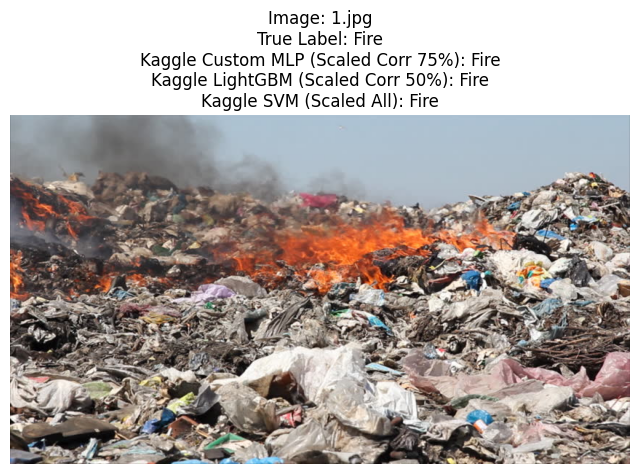


--- Processing single image: 10.jpg (Feature Models) ---


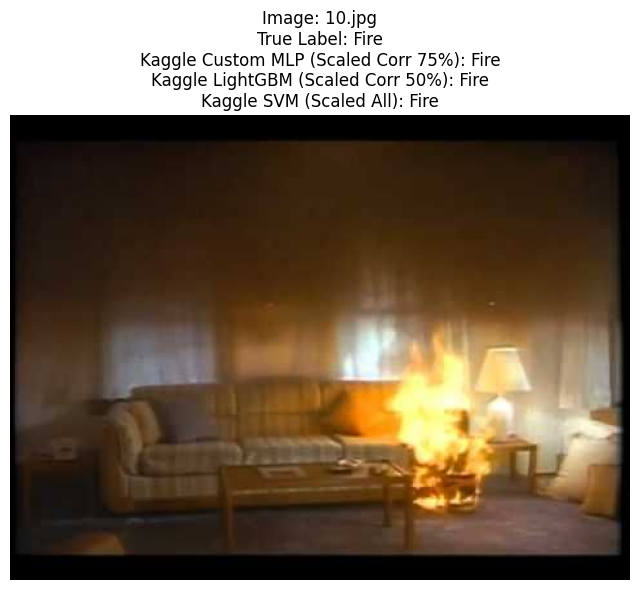


--- Processing single image: 100.jpg (Feature Models) ---


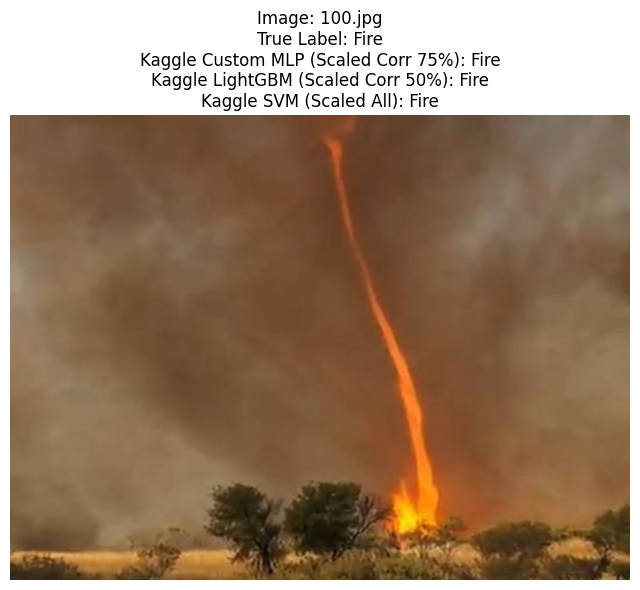


--- Processing 3 sample NON-FIRE images for display ---

--- Processing single image: 1.jpg (Feature Models) ---


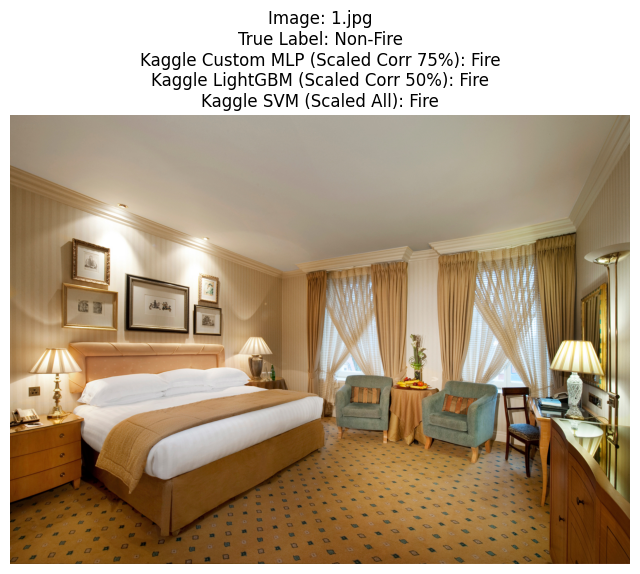


--- Processing single image: 101.jpg (Feature Models) ---


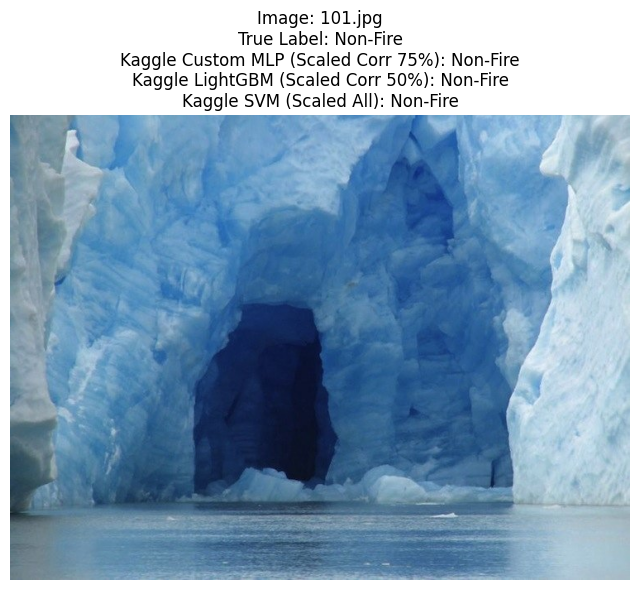


--- Processing single image: 102.jpg (Feature Models) ---


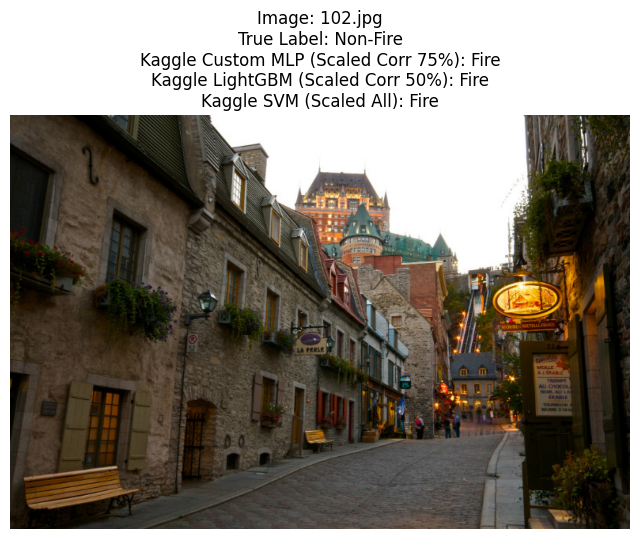


--- All kaggle Feature-Based Model Evaluations Complete ---


In [2]:
print(f"\n\n=== Kaggle Feature-Based Model Comprehensive Evaluation ===")
print(f"Project Root: {PROJECT_ROOT}")
print(f"kaggle_ROOT set to: {ROOT_EVAL}")
print(f"kaggle_TRAIN_ROOT set to: {TRAIN_ROOT_EVAL}")
print(f"kaggle_TEST_ROOT set to: {TEST_ROOT_EVAL}")
print(f"MODEL_DIR set to: {MODEL_SAVE_DIR_EVAL}")

models_to_load_and_evaluate_final = [
    {
        'display_name': 'Kaggle Custom MLP (Scaled Corr 75%)',
        'model_filename': 'real_kaggle_m1_custom_mlp_best_model_Scaled_Corr75%.keras',
        'transformer_filename': 'real_kaggle_m1_selector_Scaled_Corr75%.pkl'
    },
    {
        'display_name': 'Kaggle LightGBM (Scaled Corr 50%)',
        'model_filename': 'real_kaggle_m1_lightgbm_best_model_Scaled_Corr50%.pkl',
        'transformer_filename': 'real_kaggle_m1_selector_Scaled_Corr50%.pkl'
    },
    {
        'display_name': 'Kaggle SVM (Scaled All)',
        'model_filename': 'real_kaggle_m1_svm_best_model_Scaled_All.pkl',
        'transformer_filename': None
    }
]

global_scaler_filename = 'real_kaggle_m1_global_scaler.pkl'
global_scaler_path = os.path.join(MODEL_SAVE_DIR_EVAL, global_scaler_filename)

global_scaler_obj_eval = None
try:
    global_scaler_obj_eval = joblib.load(global_scaler_path)
    print(f"Loaded global scaler: {global_scaler_path}")
except Exception as e: print(f"Error loading global scaler: {e}. Feature-based evaluation cannot proceed.")


if global_scaler_obj_eval:
    feature_params_eval = get_feature_params()
    loaded_artifacts_eval = load_artifacts_for_feature_models_eval(models_to_load_and_evaluate_final, MODEL_SAVE_DIR_EVAL)

    if loaded_artifacts_eval:
        print("\n--- Loaded feature-based models successfully. Proceeding with evaluations. ---")
        reproduce_original_test_split_features_eval(
            TRAIN_ROOT_EVAL,
            CONFIG_EVAL,
            feature_params_eval,
            global_scaler_obj_eval,
            loaded_artifacts_eval
        )

        evaluate_feature_folder_eval(
            TEST_IMAGES_DIR_EVAL,
            loaded_artifacts_eval,
            CONFIG_EVAL,
            feature_params_eval,
            global_scaler_obj_eval
        )

        print("\n--- Preparing sample images for single image processing (Feature Models) ---")
        
        all_test_image_paths = []
        for class_dir in ['fire_images', 'non_fire_images']:
            class_path = os.path.join(TEST_IMAGES_DIR_EVAL, class_dir)
            if os.path.isdir(class_path):
                for f in os.listdir(class_path):
                    if f.lower().endswith(CONFIG_EVAL['img_extensions']):
                        all_test_image_paths.append(os.path.join(class_path, f))
        all_test_image_paths.sort() 

        fire_images_for_display = []
        non_fire_images_for_display = []

        for img_path in tqdm(all_test_image_paths, desc="Categorizing test images for display"):
            if is_kaggle_image_fire(img_path):                                          fire_images_for_display.append(img_path)
            else: non_fire_images_for_display.append(img_path)

        num_samples_to_show = min(3, len(fire_images_for_display))
        if num_samples_to_show > 0:
            print(f"\n--- Processing {num_samples_to_show} sample FIRE images for display ---")
            for i in range(num_samples_to_show):
                process_single_image_feature_model_eval(
                    fire_images_for_display[i],
                    loaded_artifacts_eval,
                    CONFIG_EVAL,
                    feature_params_eval,
                    global_scaler_obj_eval
                )
        else: print("\nNo fire images found in the test set for single image processing.")

        num_samples_to_show = min(3, len(non_fire_images_for_display))
        if num_samples_to_show > 0:
            print(f"\n--- Processing {num_samples_to_show} sample NON-FIRE images for display ---")
            for i in range(num_samples_to_show):
                process_single_image_feature_model_eval(
                    non_fire_images_for_display[i],
                    loaded_artifacts_eval,
                    CONFIG_EVAL,
                    feature_params_eval,
                    global_scaler_obj_eval
                )
        else: print("\nNo non-fire images found in the test set for single image processing.")

    else: print("No feature-based models were loaded successfully. Skipping feature-based evaluation tasks.")
else: print("Cannot proceed with feature-based model evaluation due to missing global scaler.")

print("\n--- All kaggle Feature-Based Model Evaluations Complete ---")